# Proyecto de Clasificación de Imágenes
En este proyecto, se ha desarrollado y entrenado un modelo de red neuronal convolucional (CNN) para la clasificación de imágenes de gatos y perros. El proceso abarca desde la preparación y el preprocesamiento de los datos hasta el entrenamiento, evaluación y visualización de resultados del modelo. A continuación, se describen los pasos realizados en detalle:

## Preprocesamiento de Datos con Aumento de Datos (Data Augmentation):
Se utiliza ImageDataGenerator para aplicar técnicas de aumento de datos, como rotación, desplazamiento, corte, zoom y volteo horizontal, a fin de aumentar la diversidad del conjunto de entrenamiento y mejorar la robustez del modelo.
Los datos se dividen en subconjuntos de entrenamiento y validación usando validation_split.

## Construcción del Modelo:
Se define una red neuronal convolucional con varias capas de convolución, max-pooling y dropout para evitar el sobreajuste.
La regularización L2 se utiliza para penalizar grandes pesos y ayudar a prevenir el sobreajuste.
El modelo se compila con el optimizador Adam y se utiliza la función de pérdida de categorical_crossentropy adecuada para la clasificación multiclase.

## Entrenamiento del Modelo:
El modelo se entrena utilizando los generadores de datos con un conjunto de callbacks que incluyen ModelCheckpoint para guardar el mejor modelo, ReduceLROnPlateau para reducir la tasa de aprendizaje y EarlyStopping para detener el entrenamiento temprano si no hay mejora en la validación.
Se registran las métricas de precisión y pérdida para el conjunto de entrenamiento y validación en cada época.

## Evaluación y Visualización:
Se grafican las curvas de precisión y pérdida para visualizar el desempeño del modelo durante el entrenamiento.
Se carga el mejor modelo guardado y se hacen predicciones en un conjunto de prueba para evaluar su rendimiento.

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Dropout, BatchNormalization, Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import datetime
import numpy as np

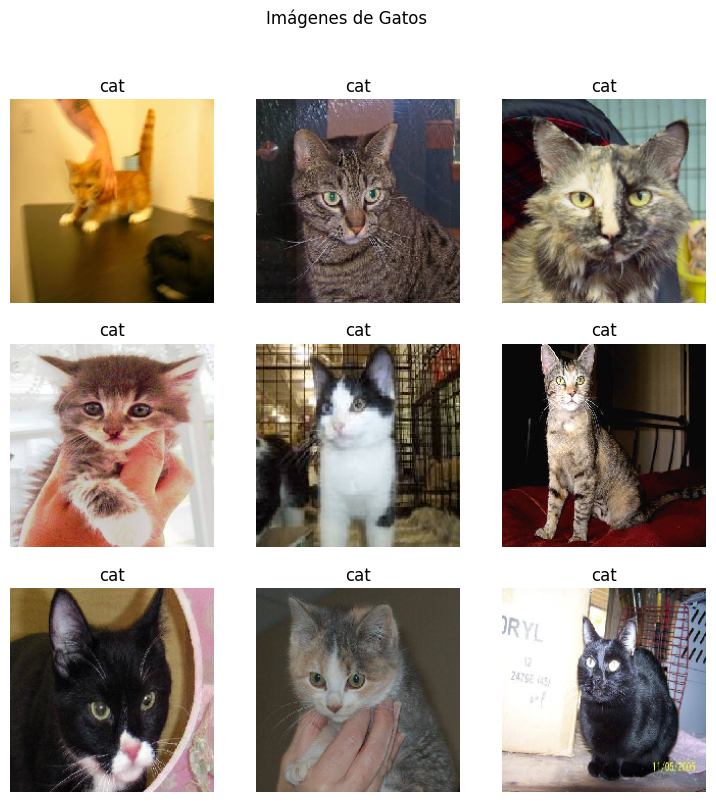

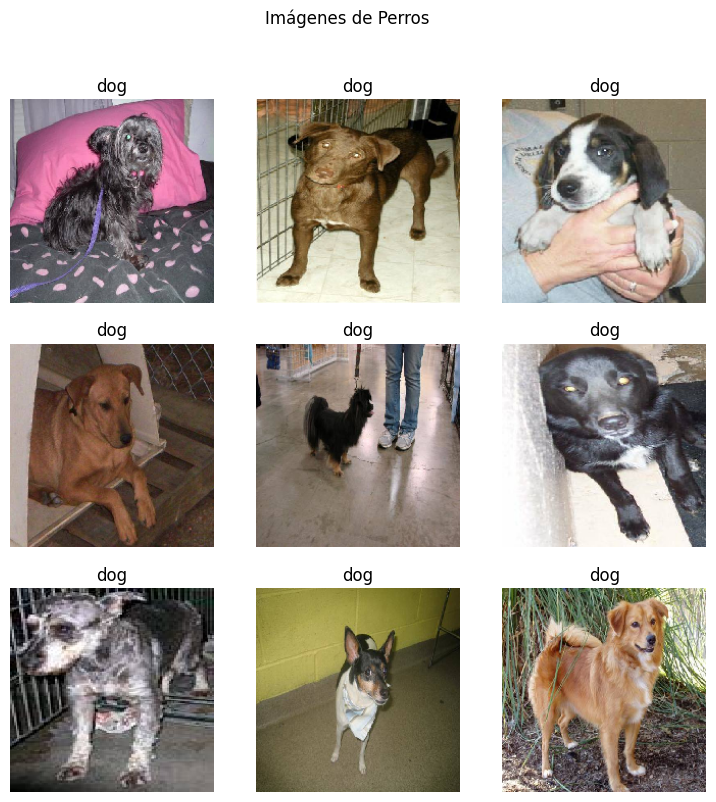

In [2]:
# Función para visualizar imágenes
def visualize_images(image_directory, title, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    axes = axes.ravel()

    images = os.listdir(image_directory)[:num_images]
    for i, img_name in enumerate(images):
        img_path = os.path.join(image_directory, img_name)
        image = load_img(img_path, target_size=(200, 200))  # Cambia el tamaño de la imagen
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(img_name.split('.')[0])

    plt.suptitle(title)
    plt.show()

# Ejecutar para visualizar imágenes de gatos
visualize_images('../data/raw/train/cats', 'Imágenes de Gatos')
# Ejecutar para visualizar imágenes de perros
visualize_images('../data/raw/train/dogs', 'Imágenes de Perros')

In [3]:
# Configuración del generador de imágenes con preprocesamiento con DataAugmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Directorio de entrenamiento
train_directory = '../data/raw/train'

# Preparar el generador de datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Especificar subconjunto para entrenamiento
)

# Preparar el generador de datos de validación
validation_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Especificar subconjunto para validación
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepara el generador de datos de test
test_directory = '../data/raw/test/'
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(200, 200),
    batch_size=32,
    class_mode=None,  # No hay etiquetas
    shuffle=False
)

Found 12500 images belonging to 1 classes.


In [5]:
# Define la ruta del mejor modelo
checkpoint_path = "../models/model_best.keras"

# Verifica si el modelo guardado existe y cárgalo, de lo contrario, crea uno nuevo
try:
    model = load_model(checkpoint_path)
    print("Modelo cargado correctamente.")
except OSError:
    print("No se encontró modelo guardado, creando un nuevo modelo.")
    # Inicializador y configuración básica
    initializer = 'he_normal'  # He initialization es común para las relu
    l2_reg = l2(0.001)  # Regularización L2
    model = Sequential([
        Input(shape=(200, 200, 3)),
        Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer=initializer),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer=initializer),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer=initializer),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation="relu", kernel_regularizer=l2_reg),
        Dropout(0.5),
        Dense(512, activation="relu", kernel_regularizer=l2_reg),
        Dropout(0.5),
        Dense(2, activation="softmax")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()


Modelo cargado correctamente.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    40,960,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,952,328 (472.84 MB)

 Trainable params: 41,317,442 (157.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,634,886 (315.23 MB)

In [6]:
print("Número de GPUs disponibles: ", len(tf.config.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("TensorFlow no detecta la GPU")

Número de GPUs disponibles:  0
TensorFlow no detecta la GPU


Epoch 1/30


c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7823 - loss: 0.4560
Epoch 1: val_accuracy improved from -inf to 0.74060, saving model to ../models/model_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 1132s 2s/step - accuracy: 0.7823 - loss: 0.4560 - val_accuracy: 0.7406 - val_loss: 0.5292 - learning_rate: 3.0000e-05
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7826 - loss: 0.4564
Epoch 2: val_accuracy improved from 0.74060 to 0.77760, saving model to ../models/model_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 964s 2s/step - accuracy: 0.7826 - loss: 0.4564 - val_accuracy: 0.7776 - val_loss: 0.4768 - learning_rate: 3.0000e-05
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7939 - loss: 0.4523
Epoch 3: val_accuracy did not improve from 0.77760
625/625 ━━━━━━━━━━━━━━━━━━━━ 958s 2s/step - accuracy: 0.7939 - loss: 0.4522 - val_accuracy: 0.7680 - val_loss: 0.4745 - learning_rate: 3.0000e-05
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7904 -

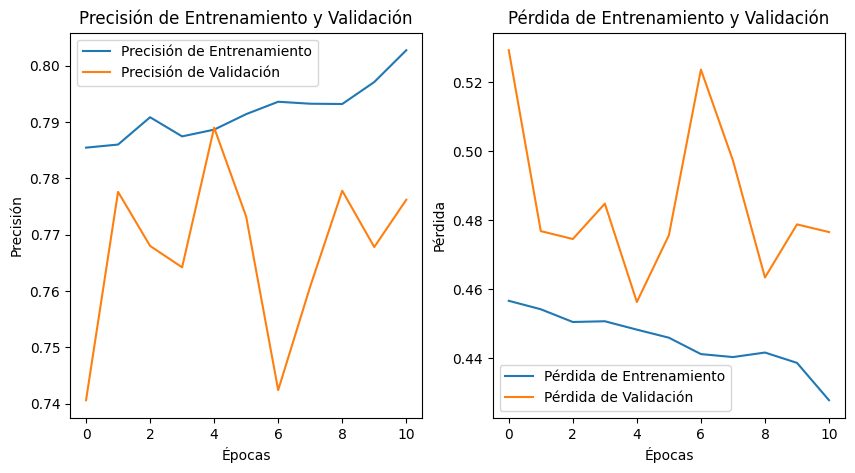

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] Se ha forzado la interrupción de una conexión existente por el host remoto
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\asyn

In [7]:
# Configuración de callbacks
    # Configuración del callback de ModelCheckpoint para guardar el mejor modelo basado en la precisión de validación
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Cambiar a monitorizar 'val_loss' o 'val_accuracy'
    verbose=1,
    save_best_only=True,
    mode='max'  # Cambiar a 'min' porque queremos minimizar la pérdida o a 'max' para aumentar la precisión (accuracy)
)

# Reducir Learning Rate basado en la pérdida de validación
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=3,
    min_lr=0.0001,
    verbose=1,
    mode='min'  # Cambiar a 'min' para minimizar la pérdida
)

    # Early stopping    
earlystopping = EarlyStopping(patience=6)


# 'history' es la salida de model.fit()
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr]
)


# Graficar la precisión de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()    


# ENTRENAMIENTO DEL MODELO
* El modelo ha sido entrenado durante varias sesiones de distintos tamaño de época. 
* El callback del Learning rate se ha mantenido en todo momento centrado en la pérdida de la validación.
* El callback de Checkpoint se ha usado en las primeras épocas (unas 15) centrado en la pérdida de la validación y en las siguientes (unas 10) centrado en la precisión en la validación.
* En la primeras épocas aumentaron mucho las métricas del training, pero no tanto las de validation. Se cambió a guardar el modelo con mejor acuraccy y empezaron a equilibrarse los resultados de validation. Queda por probar cambiar la métrica del learning rate para ver cómo afecta. No obstante, como se ha alcanzado el equilibrio entre train y validation y los resultados del test reflejan unos resultados aún mejores, por economía de tiempo en el bootcamp, paro aquí el entrenamiento.


# Análisis (último lote de épocas de entrenamiento)
El entrenamiento del modelo muestra una mejora progresiva en la precisión de entrenamiento y validación a lo largo de las épocas. A continuación, se detallan los aspectos clave del análisis:

En las primeras épocas, la precisión del entrenamiento aumenta rápidamente, pero la precisión de la validación muestra fluctuaciones significativas, lo cual indica un posible sobreajuste inicial.
Ajustes en los callbacks, como cambiar el monitoreo de val_loss a val_accuracy para guardar el mejor modelo y reducir la tasa de aprendizaje en base a la pérdida de validación, ayudan a estabilizar y equilibrar las métricas de entrenamiento y validación.
Las curvas de pérdida muestran una disminución tanto en el conjunto de entrenamiento como en el de validación, aunque con algunas oscilaciones en la pérdida de validación, lo cual es común en problemas de clasificación de imágenes debido a la variabilidad intrínseca de los datos.
Al finalizar el entrenamiento, se observa que las métricas de validación alcanzan un nivel de desempeño comparable al del conjunto de entrenamiento, indicando un buen ajuste del modelo sin sobreajuste significativo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


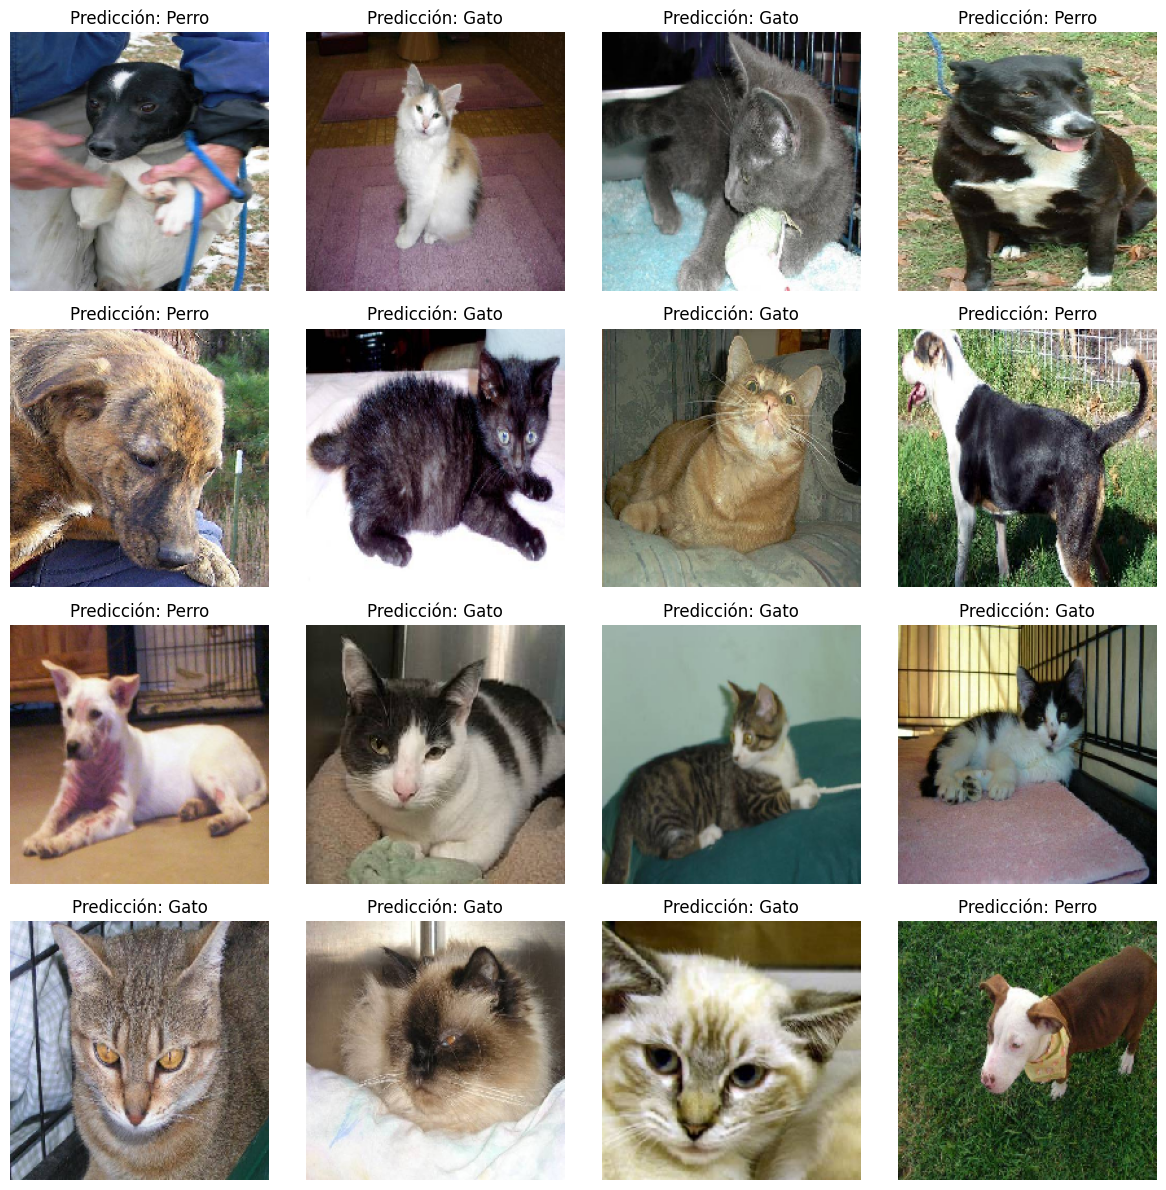

In [ ]:
# Cargar el modelo guardado
model = load_model(checkpoint_path)

# Hacer predicciones en el conjunto de test
# Obtener un lote de imágenes del test_generator
for images in test_generator:
    # Hacer predicciones en el conjunto de test
    predictions = model.predict(images)
    break  # Solo necesitamos un lote para visualizar

# Definir número de imágenes a visualizar
num_images = 16
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(num_images):
    img = images[i]
    ax = axes[i]
    ax.imshow(img)  # Mostrar la imagen original
    prediction = np.argmax(predictions[i])  # Tomar la clase con la probabilidad más alta
    label = 'Gato' if prediction == 0 else 'Perro'  
    ax.set_title(f'Predicción: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualización de Resultados en el Conjunto de Prueba
Se presentan las predicciones del modelo en un conjunto de imágenes de prueba. Cada imagen es acompañada de la etiqueta predicha, permitiendo una evaluación visual de la precisión del modelo.